In [1]:
using StatsPlots
using StatsBase
pyplot()

Plots.PyPlotBackend()

In [2]:
# two-universal hash function
# P(h(x) == h(y)) <= 1/n
module H
    # Two universal hash function generator
    function twouniversalhash(n::Int)::Function
        p::Int = 49347083 # large prime
        a::Int = rand(1:p)
        b::Int = rand(1:p)
        h(x::Int)::Int = mod(mod(a*x + b, p), n) + 1
        return h
    end
    # Collision free hash function generator
    function collisionfree(X::Vector{Int})::Function
        table::Dict{Int, Int} = Dict{Int, Int}()
        for i in eachindex(X)
            table[X[i]] = i
        end
        h(x::Int)::Int = table[x]
        return h
    end
end

Main.H

In [3]:
# n = 100,000 instances of twouniversalhash
hashers = [H.twouniversalhash(100) for _ in 1:100000];

In [4]:
one_hashes = [h(1) for h in hashers]
one_hashes = convert(Array{Integer}, one_hashes);

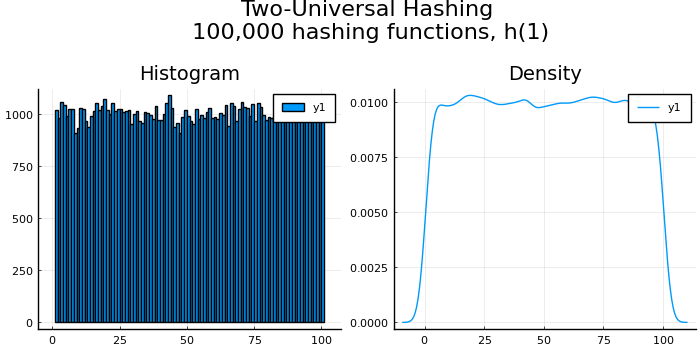

In [5]:
plot(
    histogram(one_hashes, bins=100, title="Histogram"),
    density(one_hashes, title="Density"),
    plot_title="Two-Universal Hashing\n 100,000 hashing functions, h(1)",
    size=(700, 350)
) # Nice flat distribution as expected

In [6]:
two_hashes = []
for h in hashers
    push!(two_hashes, h(2))
end
two_hashes = convert(Array{Integer}, two_hashes);

In [7]:
# P(h(x) == h(y)) <= 1/n

collisions = sum(one_hashes .== two_hashes)
expected_collisions = convert(Integer, 100000 * (1/100))
println("expected collisions: $expected_collisions")
println("collisions: $collisions")

expected collisions: 1000
collisions: 952


In [8]:
# Two level hashing
# O(1) lookup time, O(m) space, where m = number of items hashed
module TLH
    using Main.H
    const H = Main.H
    # Second level hash table
    struct SecondHash
        X::Vector{Int}
        h::Function
        table::Array{Int}
        SecondHash(X) = new(X, H.collisionfree(X), Array{Int}(undef, size(X)[1]))
    end
    # First level hash table
    struct TwoLevelHashTable
        n::Int
        h::Function
        holdingbags::Array{Array{Int}}
        table::Array{SecondHash}
        TwoLevelHashTable(n) = new(n, H.twouniversalhash(n), [[] for _ in 1:n], Array{SecondHash}(undef, n))
    end
    # Insert into list at hash index
    function firstlevel!(t::TwoLevelHashTable, X::Vector{Int})::Nothing
        for x in X
            hash = t.h(x)
            push!(t.holdingbags[hash], x)
        end
        return nothing
    end
    # Create second level hash tables from list of lists
    function secondlevel!(t::TwoLevelHashTable)::Nothing
        for i in eachindex(t.holdingbags)
            t.table[i] = SecondHash(t.holdingbags[i])
            for x in t.holdingbags[i]
                hash = t.table[i].h(x)
                t.table[i].table[hash] = x
            end
        end
        return nothing
    end
    # All together now
    # n = hash table size (in first layer)
    # X = Ints to hash
    function maketable(n::Int, X::Vector{Int})::TwoLevelHashTable
        table::TwoLevelHashTable = TwoLevelHashTable(n)
        firstlevel!(table, X)
        secondlevel!(table)
        return table
    end
    # get an item
    function getitem(t::TwoLevelHashTable, x::Int)::Tuple{Int, Int, Int}
        firstindex::Int = t.h(x)
        secondindex::Int = t.table[firstindex].h(x)
        return (firstindex, secondindex, t.table[firstindex].table[secondindex])
    end
    # print the table
    function printtable(t::TwoLevelHashTable)::Nothing
        arr::Array{Array{Int}} = Array{Array{Int}}(undef, t.n)
        for i in eachindex(t.table)
            arr[i] = t.table[i].table
        end
        println(arr)
        return nothing
    end
end

Main.TLH

In [9]:
twolevelhashtable = TLH.maketable(10, [100, 5, 20, 1, 75, 662, 90, 42])
TLH.printtable(twolevelhashtable)
TLH.getitem(twolevelhashtable, 20), TLH.getitem(twolevelhashtable, 75)

Array{Int64}[[], [], [], [662, 42], [], [75, 90], [], [100, 5, 20, 1], [], []]


((8, 3, 20), (6, 1, 75))

In [10]:
module BF
    using Main.H
    const H = Main.H
    struct BloomFilter
        m::Int
        k::Int
        h::Vector{Function}
        table::Vector{Integer}
        BloomFilter(m, k) = new(m, k, [H.twouniversalhash(m) for _ in 1:k], zeros(Int, m))
    end
    function insert!(b::BloomFilter, X::Vector{Int})::Nothing
        for x in X
            for hasher in b.h
                b.table[hasher(x)] = 1
            end
        end
        return nothing
    end
    function query(b::BloomFilter, x::Int)::Bool
        for hasher in b.h
            if b.table[hasher(x)] == 0
                return false
            end
        end
        return true
    end
    function printtable(b::BloomFilter)::Nothing
        println(b.table)
        return nothing
    end
end

Main.BF

In [17]:
bloomfilter = BF.BloomFilter(500, 5)
randomlist = rand(1:1000000, 100)
BF.insert!(bloomfilter, randomlist)
BF.printtable(bloomfilter)

Integer[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [20]:
for x in randomlist
    exists = BF.query(bloomfilter, x)
    if !exists
        println(x, "not found")
    end
end
"done"

"done"